In [1]:
import os,sys
import datetime

### Import scanpy

In [2]:
import scanpy.api as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.3.4 anndata==0.6.13 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 
Memory usage: current 0.17 GB, difference +0.17 GB


### Import my utility functions and import statements from github

In [3]:
"""# This cell is run once to download my custom functions and import statements from github

!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
    
# github doesn't seem to have an option to download a specific version of the repo from the history.
# So I download my utility functions and save the download time by appending it to the directory name.
# These utility functions to be shared together with the notebook.

toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
newname = "utility_functions_%s"%toappend
print(newname)


# rename the py file with utility functions
os.rename("utility_functions",newname)"""

'# This cell is run once to download my custom functions and import statements from github\n\n!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions\n    \n# github doesn\'t seem to have an option to download a specific version of the repo from the history.\n# So I download my utility functions and save the download time by appending it to the directory name.\n# These utility functions to be shared together with the notebook.\n\ntoappend = datetime.datetime.now().strftime(\'%y%m%d_%Hh%M\')\nnewname = "utility_functions_%s"%toappend\nprint(newname)\n\n\n# rename the py file with utility functions\nos.rename("utility_functions",newname)'

In [4]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_190425_11h32"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import
import rz_utility_spring as srz

python version: 3.6.7


# Part1: prepare and save data for use with the R notebook FateID_R_code

## Load data and place into an annData object

In [5]:
!ls data_from_geo

average_gene_expression_per_population.tsv
cell_info_8594x25.tsv
control_barcodes.tsv
control_genes.tsv
control_loom.loom
control_matrix.mtx
gene_names_alphabetically.txt
injury_barcodes.tsv
injury_genes.tsv
injury_loom.loom
injury_matrix.mtx
raw_counts_8594x27998.mtx


In [6]:
obspath = 'data_from_geo/cell_info_8594x25.tsv'
countpath = 'data_from_geo/raw_counts_8594x27998.mtx'
genepath = 'data_from_geo/gene_names_alphabetically.txt'

In [7]:
# load cell info
obs = pd.read_csv(obspath,sep='\t',index_col=0)
print(obs.shape)
obs.head()

(8594, 25)


,barcode,condition,total_counts,pass_quality_filters,inj_epithelial,ctr_epithelial,excluded_as_immune_or_mesench,class,population,phase,...,x_control,y_control,x_class3_exploded,y_class3_exploded,x_control_injured,y_control_injured,x_class1_CTR_cell_cyc_removed,y_class1_CTR_cell_cyc_removed,x_class1_INJ_cell_cyc_removed,y_class1_INJ_cell_cyc_removed
0,AAACCTGAGTGCTGCC-1,control,2787,True,False,True,False,class3,ctr_DEEx,G1,...,783.705500,-377.074709,1082.172898,-266.303304,709.78614,-325.505019,NaN,NaN,NaN,NaN
1,AAACCTGAGTGGGTTG-1,control,3325,True,False,True,False,class3,ctr_upper_IEE,G1,...,709.612642,-429.409941,854.230866,-454.025809,529.15516,-471.961493,NaN,NaN,NaN,NaN
2,AAACCTGCAAGTCTAC-1,control,1781,False,False,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAACCTGCAATCTGCA-1,control,3468,True,False,False,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAACCTGCACGGTGTC-1,control,1745,False,False,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# load counts
adata = sc.read_mtx(countpath)
print(adata.shape)

# add genes (annotation of variables)
adata.var['genes'] = np.loadtxt(genepath,dtype=str)

# make sure var names are genes
adata.var_names = adata.var['genes'].values

# add obs (annotation of observations)
adata.obs = obs

# make sure index is unique AND a string
adata.obs_names_make_unique()
adata.obs_names = adata.obs_names.astype(str)

(8594, 27998)


### Scale (normalize) data

In [9]:
# turn into counts per 10k
print(adata.X[:5,:].sum(axis=1))
print()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
print(adata.X[:5,:].sum(axis=1))

[[2787.]
 [3325.]
 [1781.]
 [3468.]
 [1745.]]

[[10000.   ]
 [10000.   ]
 [10000.001]
 [10000.   ]
 [ 9999.999]]


### Let's restrict the analysis to genes used for making the SPRING plot, e.g. exclude cells cycle genes, RPS, RPL, etc.   
I have this info in the SPRING directory

In [10]:
spring_dir = "SPRING_dev-master/datasets/Sharir_et_al_2019/control_epithelial_no_cc/"
params = rz.load_stuff(spring_dir+"params.pickle")
genes_used = params['genes_used']
print(len(genes_used))

2000


In [11]:
# also load xy coordinates for visualizing results
coo = pd.read_csv(spring_dir+'coordinates.txt',
                  index_col=0,header=None)

print(coo.shape)

cmask = adata.obs['ctr_epithelial'].astype(bool).values
adata.obs['x_control_no_cc'] = np.nan
adata.obs['y_control_no_cc'] = np.nan
adata.obs.loc[cmask,'x_control_no_cc'] = coo[1].values
adata.obs.loc[cmask,'y_control_no_cc'] = -coo[2].values

(2349, 2)


In [12]:
!mkdir -p outputs/fateid

In [13]:
# prepare boolean masks for selecting genes and cells
cmask = adata.obs['ctr_epithelial'].astype(bool).values
gmask = np.in1d(adata.var_names,genes_used)
print(cmask.sum(),gmask.sum())

# save as dense tsv file to easy loading in R
X = pd.DataFrame(adata.X[cmask,:][:,gmask].toarray())
X.columns = adata.var_names[gmask]
X = X.T
X.to_csv('outputs/fateid/counts_%dx%d.tsv'%(X.shape[0],X.shape[1]),sep='\t')

2349 2000


In [14]:
# save population info
pops = adata[cmask].obs[['population']]
pops.reset_index(drop=True,inplace=True)

In [15]:
# fate id requires population labels as integers, let's create a dictionary and save it:
renamer = {pop:nr for nr,pop in enumerate(pops['population'].unique())}
# save
pd.Series(renamer).to_csv('outputs/fateid/population_label_lookup.tsv',sep='\t')
renamer

{'ctr_DEEx': 0,
 'ctr_upper_IEE': 1,
 'ctr_M_G1': 2,
 'ctr_OEE_IEE': 3,
 'ctr_G2_M': 4,
 'ctr_OEE_2': 5,
 'ctr_OSR': 6,
 'ctr_SI': 7,
 'ctr_S': 8,
 'ctr_VEE': 9,
 'ctr_pre_AMB': 10,
 'ctr_OEE_1': 11,
 'ctr_AMB_dist': 12,
 'ctr_AMB_prox': 13,
 'ctr_ISR_SI': 14}

In [16]:
# rename, transpose
pops['population'] = [renamer[i] for i in pops['population']]
pops = pops.T

In [17]:
print(np.allclose(pops.columns,X.columns))
fname = 'outputs/fateid/population_labels_%dx%d.tsv'%(pops.shape[0],pops.shape[1])
print(fname)
pops.to_csv(fname,sep='\t')

True
outputs/fateid/population_labels_1x2349.tsv


In [18]:
# endpoint populations
endpoints = ["ctr_OEE_1","ctr_VEE","ctr_ISR_SI","ctr_OSR","ctr_SI","ctr_AMB_dist","ctr_OEE_2"]
endpoints_nr = [renamer[i] for i in endpoints]
print(endpoints_nr)

# save this vector:
np.savetxt('outputs/fateid/labels_to_consider.tsv',endpoints_nr,fmt="%d")

[11, 9, 14, 6, 7, 12, 5]


In [19]:
!open outputs

### Run the notebook FateID_get_distance_matrix.ipynb
### Run the notebook FateID_R_code

# Part2: Load and plot FateID results

In [20]:
# cluster colors used in the paper
cdict = {
'ctr_AMB_dist': '#cdceca',
'inj_AMB_dist': '#cdceca',
'ctr_AMB_prox': '#a0a2a1',
'inj_AMB_prox': '#a0a2a1',
'ctr_G2_M': '#344683',
'inj_G2_M': '#344683',
'ctr_OSR': '#b9938f',
'inj_OSR': '#b9938f',
'ctr_M_G1': '#607dac',
'inj_M_G1': '#607dac',
'ctr_ISR_SI': '#eb4034',
'inj_ISR_SI': '#eb4034',
'ctr_S': '#a8bad4',
'inj_S': '#a8bad4',
'ctr_SI': '#513230',
'inj_SI': '#513230',
'ctr_OEE_1': '#eddd00',
'inj_OEE_1': '#eddd00',
'ctr_DEEx': '#948f35',
'inj_DEEx': '#948f35',
'ctr_OEE_2': '#df9445',
'inj_OEE_2': '#df9445',
'ctr_pre_AMB': '#6c6d6a',
'inj_pre_AMB': '#6c6d6a',
'ctr_upper_IEE': '#302651',
'inj_upper_IEE': '#302651',
'ctr_OEE_IEE': '#a64a03',
'inj_OEE_IEE': '#a64a03',
'ctr_VEE': '#773579',
'inj_VEE': '#773579'}

In [21]:
probs = pd.read_csv("outputs/fateid/resulting_probs_custom_dist_2k_genes_7pop.tsv",sep='\t')
print(probs.shape)
probs.head(2)

(2349, 7)


,t11,t9,t14,t6,t7,t12,t5
X0,0.152,0.070,0.304,0.116,0.10,0.118,0.140
X1,0.104,0.026,0.114,0.276,0.28,0.118,0.082


In [22]:
# back-rename:
renamer_r = {str(value):key for key,value in renamer.items()}
probs.columns = [renamer_r[i[1:]] for i in probs.columns]
probs.head(2)

,ctr_OEE_1,ctr_VEE,ctr_ISR_SI,ctr_OSR,ctr_SI,ctr_AMB_dist,ctr_OEE_2
X0,0.152,0.070,0.304,0.116,0.10,0.118,0.140
X1,0.104,0.026,0.114,0.276,0.28,0.118,0.082


/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


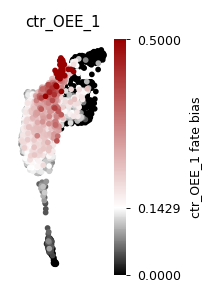

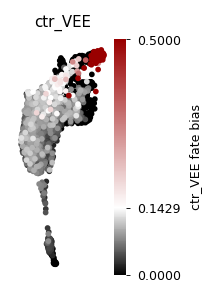

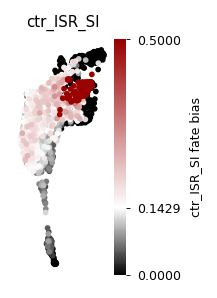

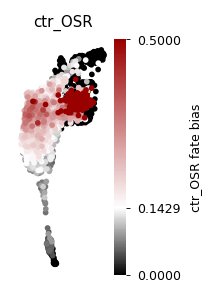

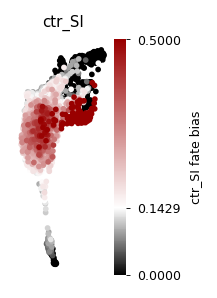

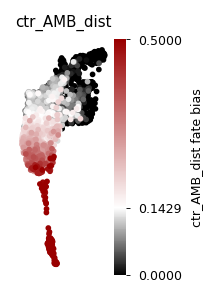

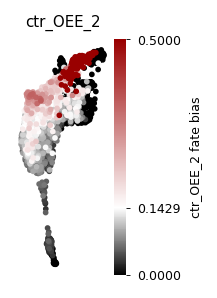

In [23]:
x = adata[cmask].obs['x_control_no_cc'].values
y = adata[cmask].obs['y_control_no_cc'].values
vmin=0
vmax=0.5

#cmap = plt.cm.get_cmap('RdBu_r')
cbarticks = [vmin,1/probs.shape[1],vmax]
cmap = rz.custom_colormap(['#000000','#ffffff','#990000'],cbarticks)

for target in probs.columns:
    c = probs[target].values
    
    order = np.argsort(c)
    
    xs = x[order]
    ys = y[order]
    c = c[order]
    
    a,fig,gs = rz.startfig(3.5,5,frameon=False)
    scatter = a.scatter(xs,ys,c=c,cmap=cmap,s=3,vmin=vmin,vmax=vmax)
    a.set_xticks([])
    a.set_yticks([])
    a.set_title(target)
    cbar = fig.colorbar(scatter)
    cbar.outline.set_visible(False)
    cbar.set_label('%s fate bias'%target)
    cbar.set_ticks(cbarticks)
    
    gs.tight_layout(fig)
    
    plt.savefig('outputs/fateid/fate_scatter_%s.png'%target,dpi=300)
    plt.savefig('outputs/fateid/fate_scatter_%s.pdf'%target)
    plt.show()

### Average probability per population

In [24]:
avg = probs.copy()

# add a column for population name
avg['population'] = adata[cmask].obs['population'].values

# Get a special colotrack: merge class 2,3-like cells with their non-cycling counterparts
msk = (adata[cmask].obs['class'] == 'class1').values
print(msk.sum(),msk.shape,probs.shape)

avg.loc[msk,'population'] = [i[:-5] for i in adata.obs[cmask][msk]['class2_3_like']]
print(avg['population'].unique())

# leave a copy of the colortrack for use later:
popvector = avg['population'].values

# get average
avg = avg.groupby('population').mean()

862 (2349,) (2349, 7)
['ctr_DEEx' 'ctr_upper_IEE' 'ctr_pre_AMB' 'ctr_OEE_IEE' 'ctr_OEE_2'
 'ctr_OSR' 'ctr_SI' 'ctr_VEE' 'ctr_OEE_1' 'ctr_AMB_dist' 'ctr_AMB_prox'
 'ctr_ISR_SI']


In [25]:
hier_dict = rz.hier_cluster(avg,method='average',metric='euclidean')
heat = hier_dict['data']

In [26]:
help(cbar.set_ticks)

Help on method set_ticks in module matplotlib.colorbar:

set_ticks(ticks, update_ticks=True) method of matplotlib.colorbar.Colorbar instance
    Set tick locations.
    
    Parameters
    ----------
    ticks : {None, sequence, :class:`~matplotlib.ticker.Locator` instance}
        If None, a default Locator will be used.
    
    update_ticks : {True, False}, optional
        If True, tick locations are updated immediately.  If False,
        use :meth:`update_ticks` to manually update the ticks.



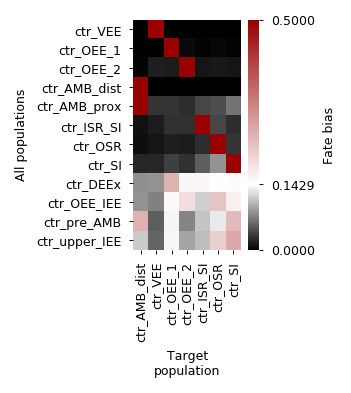

In [27]:
vmin = 0
vmax = 0.5

cbarticks = [vmin,1/heat.shape[1],vmax]
cmap = rz.custom_colormap(['#000000','#ffffff','#990000'],cbarticks)

a,fig,gs = rz.startfig(6,7,frameon=False)
hmap = a.matshow(heat,vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto')
a.xaxis.tick_bottom()
a.set_yticks(np.arange(heat.shape[0]));
a.set_xticks(np.arange(heat.shape[1]));
a.set_yticklabels(heat.index)
a.set_xticklabels(heat.columns,rotation=90)
cbar = fig.colorbar(hmap)
cbar.set_ticks(cbarticks)
cbar.outline.set_visible(False)
a.set_xlabel('Target\npopulation')
a.set_ylabel('All populations')
cbar.set_label('Fate bias')

gs.tight_layout(fig,pad=2)

plt.savefig('outputs/fateid/heatmap.pdf',dpi=600)

In [28]:
"""# barchart of mean variance
h = avg.var(axis=1).sort_values()
#h = h.max()-h
x = np.arange(len(h))
color = [cdict[i] for i in h.index]

a,fig,gs = rz.startfig(5,4)
a.bar(x,h,color=color)

a.set_xticks(x)
a.set_xticklabels(h.index,rotation=90);
#a.set_ylabel('var_max-var')
a.set_ylabel('Fate bias variance')

rz.showspines(a,bottom=True,left=True)

gs.tight_layout(fig)

#plt.savefig('outputs/fateid/fateid_var_max_minus_var_bars.pdf')
#plt.savefig('outputs/fateid/fateid_var_bars.pdf')"""

"# barchart of mean variance\nh = avg.var(axis=1).sort_values()\n#h = h.max()-h\nx = np.arange(len(h))\ncolor = [cdict[i] for i in h.index]\n\na,fig,gs = rz.startfig(5,4)\na.bar(x,h,color=color)\n\na.set_xticks(x)\na.set_xticklabels(h.index,rotation=90);\n#a.set_ylabel('var_max-var')\na.set_ylabel('Fate bias variance')\n\nrz.showspines(a,bottom=True,left=True)\n\ngs.tight_layout(fig)\n\n#plt.savefig('outputs/fateid/fateid_var_max_minus_var_bars.pdf')\n#plt.savefig('outputs/fateid/fateid_var_bars.pdf')"

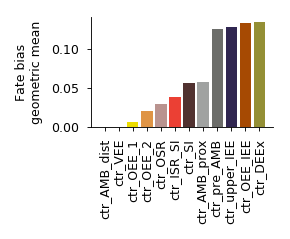

In [29]:
# barchart of geometric mean of fate bias
h = (avg.prod(axis=1)**(1./avg.shape[1])).sort_values()

x = np.arange(len(h))
color = [cdict[i] for i in h.index]

a,fig,gs = rz.startfig(5,4)
a.bar(x,h,color=color)

a.set_xticks(x)
a.set_xticklabels(h.index,rotation=90);
a.set_ylabel('Fate bias\ngeometric mean')

rz.showspines(a,bottom=True,left=True)

gs.tight_layout(fig)

plt.savefig('outputs/fateid//fateid_geomean_bars.pdf')

ctr_OEE_1 36
ctr_VEE 73
ctr_ISR_SI 120
ctr_OSR 186
ctr_SI 152
ctr_AMB_dist 26
ctr_OEE_2 133


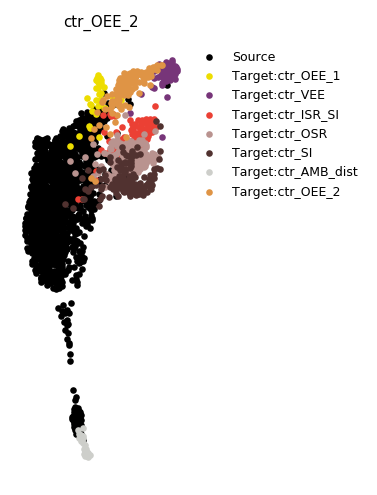

In [30]:
x = adata[cmask].obs['x_control_no_cc'].values
y = adata[cmask].obs['y_control_no_cc'].values
a,fig,gs = rz.startfig(8,10,frameon=False)

msk = ~np.in1d(popvector,endpoints)

a.scatter(x[msk],y[msk],s=10,lw=0,c='0',label='Source')


for i in endpoints:
    msk = popvector == i
    print(i,sum(msk))
    
    color = cdict[i]
    a.scatter(x[msk],y[msk],s=10,lw=0,c=color,label='Target:%s'%i)

plt.legend(bbox_to_anchor=(1,1))

a.set_xticks([])
a.set_yticks([])
a.set_title(target)

gs.tight_layout(fig,pad=5)

plt.savefig('outputs/fateid/targets.png',dpi=300)
plt.savefig('outputs/fateid/targets.pdf')
plt.show()